In [20]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hsx9_qha
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hsx9_qha
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [26]:
# Import libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import clip

In [27]:
# Load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [28]:
# Load CIFAR-10 dataset and split
dataset = CIFAR10(root="./", train=True, download=True, transform=clip_preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 46.1MB/s]


In [29]:
# Dummy SimCLR & BYOL models (replace with trained models or load checkpoints)
class DummyEncoder(torch.nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3 * 224 * 224, 512),  # CLIP resizes CIFAR10 to 224x224
            torch.nn.ReLU(),
            torch.nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

simclr_model = DummyEncoder().to(device)
byol_model = DummyEncoder().to(device)
simclr_model.eval()
byol_model.eval()

DummyEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
)

In [30]:

# Extract embeddings for training data
train_features = []
train_labels = []
with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        clip_feats = clip_model.encode_image(images)
        simclr_feats = simclr_model(images)
        byol_feats = byol_model(images)

        fused_feats = torch.cat([clip_feats, simclr_feats, byol_feats], dim=1)
        train_features.append(fused_feats.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features).numpy()
train_labels = torch.cat(train_labels).numpy()
train_features = normalize(train_features)

In [31]:
# KMeans Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_features)
train_pred_labels = kmeans.labels_

In [32]:
# Extract embeddings for test data
test_features = []
test_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        clip_feats = clip_model.encode_image(images)
        simclr_feats = simclr_model(images)
        byol_feats = byol_model(images)

        fused_feats = torch.cat([clip_feats, simclr_feats, byol_feats], dim=1)
        test_features.append(fused_feats.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features).numpy()
test_labels = torch.cat(test_labels).numpy()
test_features = normalize(test_features)


In [33]:
# Predict on test data
test_pred_labels = kmeans.predict(test_features)

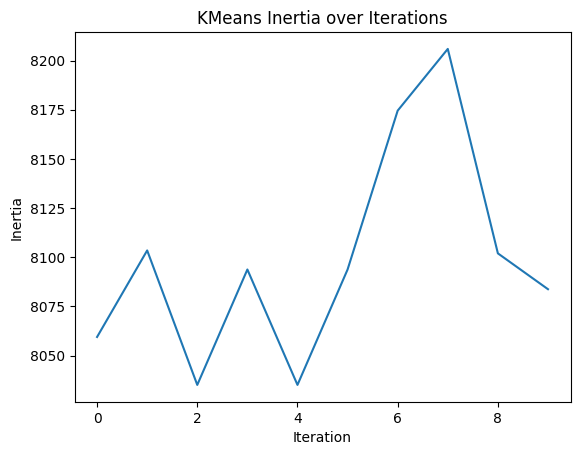

In [34]:
inertia_values = []
for i in range(10):
  kmeans = KMeans(n_clusters=10, random_state=i)
  kmeans.fit(train_features)
  inertia_values.append(kmeans.inertia_)

plt.plot(inertia_values)
plt.xlabel("Iteration")
plt.ylabel("Inertia")
plt.title("KMeans Inertia over Iterations")
plt.show()

Accuracy on Test Data: 0.7422

Classification Report on Test Data:
               precision    recall  f1-score   support

           0     0.9784    0.7841    0.8705       982
           1     0.9828    0.9456    0.9639      1030
           2     0.7303    0.5939    0.6551       985
           3     0.2060    0.1309    0.1600      1001
           4     0.8807    0.7444    0.8068       982
           5     0.5335    0.8282    0.6489      1001
           6     0.4321    0.6912    0.5318      1004
           7     0.9808    0.8398    0.9048      1036
           8     0.9849    0.9178    0.9502       997
           9     0.9428    0.9399    0.9414       982

    accuracy                         0.7422     10000
   macro avg     0.7652    0.7416    0.7433     10000
weighted avg     0.7655    0.7422    0.7438     10000



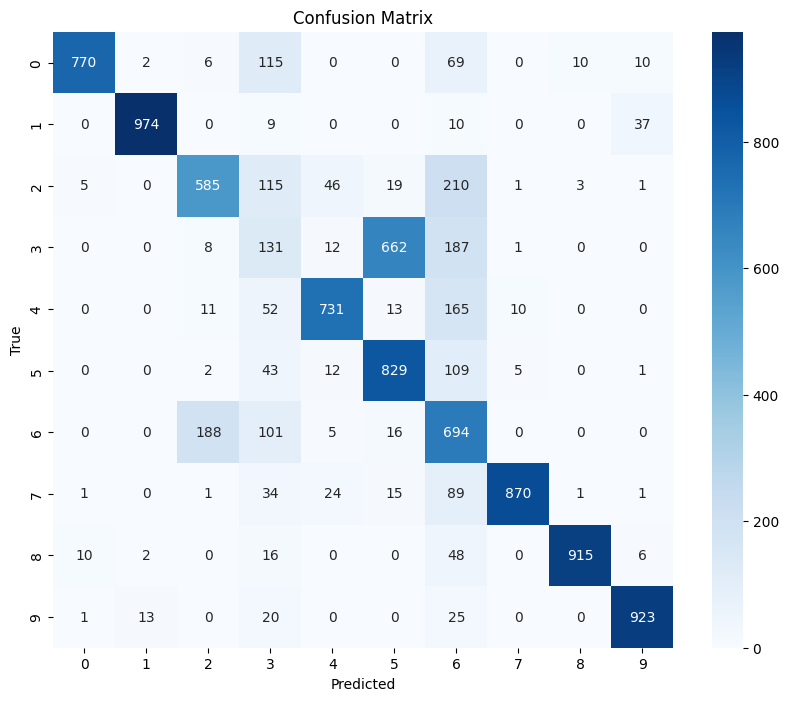

In [35]:
# Evaluation on test data
# Map predicted clusters to true labels using Hungarian algorithm
from scipy.optimize import linear_sum_assignment

conf_matrix = confusion_matrix(test_labels, test_pred_labels)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
mapping = dict(zip(col_ind, row_ind))
test_pred_mapped = np.vectorize(mapping.get)(test_pred_labels)

acc = accuracy_score(test_labels, test_pred_mapped)
report = classification_report(test_labels, test_pred_mapped, digits=4)
conf_matrix_mapped = confusion_matrix(test_labels, test_pred_mapped)

print("Accuracy on Test Data:", acc)
print("\nClassification Report on Test Data:\n", report)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mapped, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

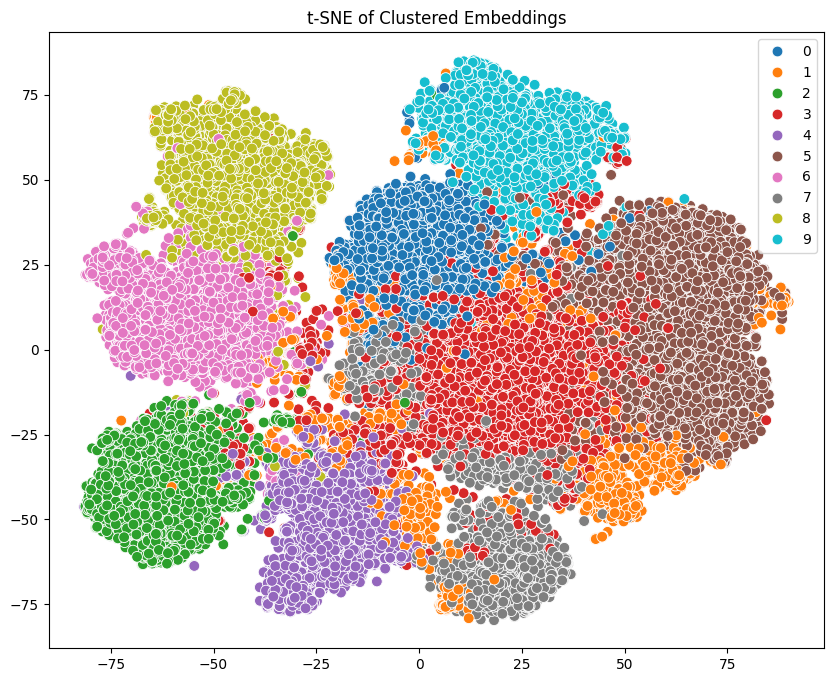

In [36]:
# t-SNE Visualization
# Combine train and test features for visualization
all_features = np.concatenate([train_features, test_features])
all_pred_labels = np.concatenate([train_pred_labels, test_pred_labels])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=all_pred_labels, palette='tab10', s=60, legend='full')
plt.title("t-SNE of Clustered Embeddings")
plt.show()